In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
df_spy = pd.read_csv("spy_weekly_return_detailed.csv")
df_atvi = pd.read_csv("atvi_weekly_return_detailed.csv")

In [3]:
df_atvi_yr1 = df_atvi[df_atvi["Year"] == 2021]
df_atvi_yr2 = df_atvi[df_atvi["Year"] == 2022]

df_spy_yr1 = df_spy[df_spy["Year"] == 2021]
df_spy_yr2 = df_spy[df_spy["Year"] == 2022]

In [4]:
df_atvi_yr1["Predicted_Next"] = np.nan
df_atvi_yr2["Predicted_Next"] = np.nan

df_spy_yr1["Predicted_Next"] = np.nan
df_spy_yr2["Predicted_Next"] = np.nan

<ipython-input-4-feb782b786a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atvi_yr1["Predicted_Next"] = np.nan
<ipython-input-4-feb782b786a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atvi_yr2["Predicted_Next"] = np.nan
<ipython-input-4-feb782b786a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [10]:
def optimal_w(df, stocks):
    w = np.arange(5, 31)
    avg_pl = []
    for i in range(w.shape[0]):
        profit_loss_per_trade = []
        for j in range(df.shape[0]-w[i]):
            prev_days = df.iloc[j:j+w[i], :]
            x = np.arange(1, w[i]+1).reshape(-1, 1)
            y = prev_days["Adj Close"].values.reshape(-1, 1)
            lm_i = LinearRegression().fit(x, y)
            prediction_next = lm_i.predict(np.array([i+1]).reshape(-1, 1))
            df.iat[j+w[i], -1] = prediction_next
            
        position = None
        for j in range(w[i], df.shape[0] - 1):
            if df.iloc[j, -1] > df.iloc[j, 4]:
                if position == "Short":
                    profit_loss_per_trade.append(df.iloc[j, 4] - sp)
                position = "Long"
                lp = df.iloc[j, 4]
            elif df.iloc[j, -1] < df.iloc[j, 4]:
                if position == "Long":
                    profit_loss_per_trade.append(lp - df.iloc[j, 4])
                position = "Short"
                sp = df.iloc[j, 4]
            elif position == 'Long':
                profit_loss_per_trade.append(lp - df.iloc[j, 4])
                position = None
            elif position == 'Short':
                profit_loss_per_trade.append(df.iloc[j, 4] - sp)
                position = None
        if position == "Long":
            profit_loss_per_trade.append(lp - df.iloc[-1, 4])
        elif position == "Short":
            profit_loss_per_trade.append(df.iloc[-1, 4] - sp)
        avg_pl.append(np.mean(profit_loss_per_trade))
    
    plt.figure(figsize = (15, 10))
    plt.plot(w, avg_pl)
    plt.xlabel("Window Sizes")
    plt.ylabel("Average Profit/Loss")
    plt.title(f"Window Size Profits/Losses for {stocks}")
    plt.show()
    
    best_w = w[np.array(avg_pl).argmax()]
    print(F"Best W ->", best_w)

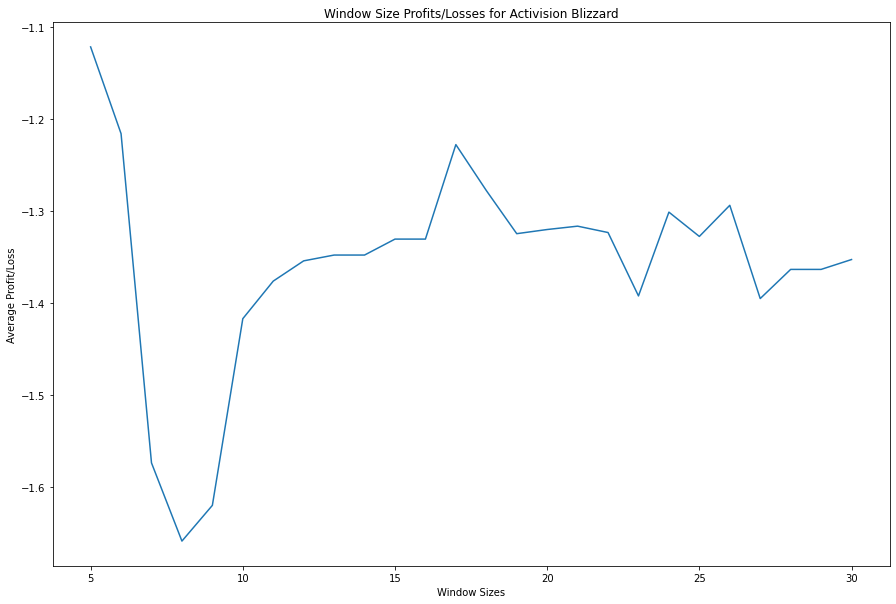

Best W -> 5


In [11]:
optimal_w(df_atvi_yr1,"Activision Blizzard")

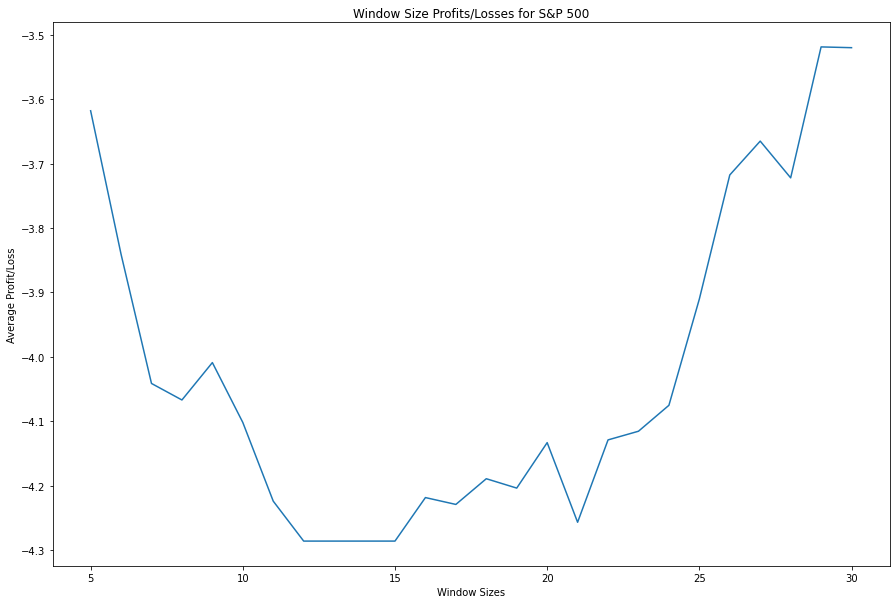

Best W -> 29


In [9]:
optimal_w(df_spy_yr1,"S&P 500")

In [12]:
def get_r2_score(df, stocks, w_best):
    w_star = w_best
    values = []
    for j in range(df.shape[0]-w_star):
        prev_days = df.iloc[j:j+w_star, :]
        x = np.arange(1, w_star+1).reshape(-1, 1)
        y = prev_days["Adj Close"].values.reshape(-1, 1)
        lm_i = LinearRegression().fit(x, y)
        predictions = lm_i.predict(x)
        r2 = r2_score(y, predictions)
        values.append(r2)
    
    plt.figure(figsize = (15, 10))
    plt.plot(values)
    plt.xlabel("Days")
    plt.ylabel("R-2 Scores")
    plt.title(f"R^2 scores for {stocks}")
    plt.show()
    
    print("Average R^2 value ->", np.mean(values))

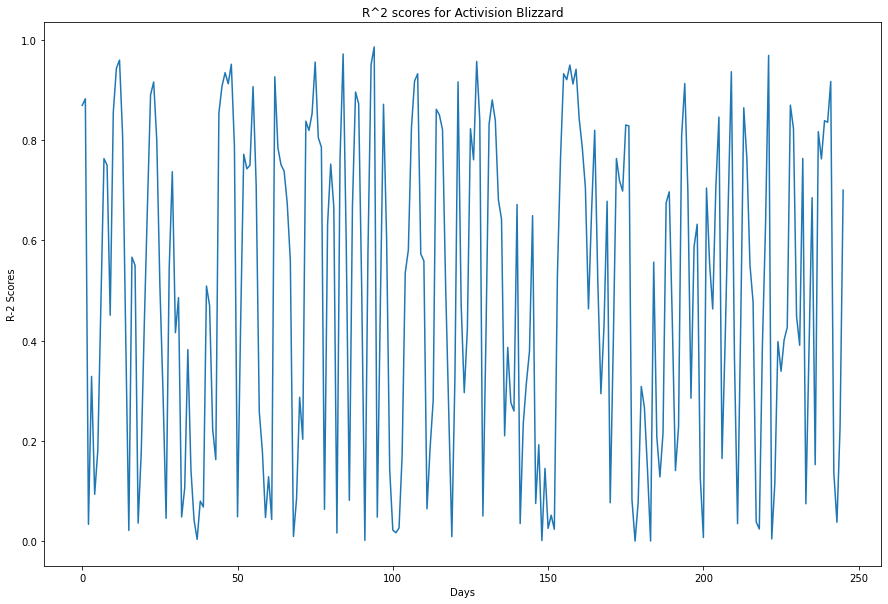

Average R^2 value -> 0.49573756002365366


In [13]:
get_r2_score(df_atvi_yr2, "Activision Blizzard", 5)

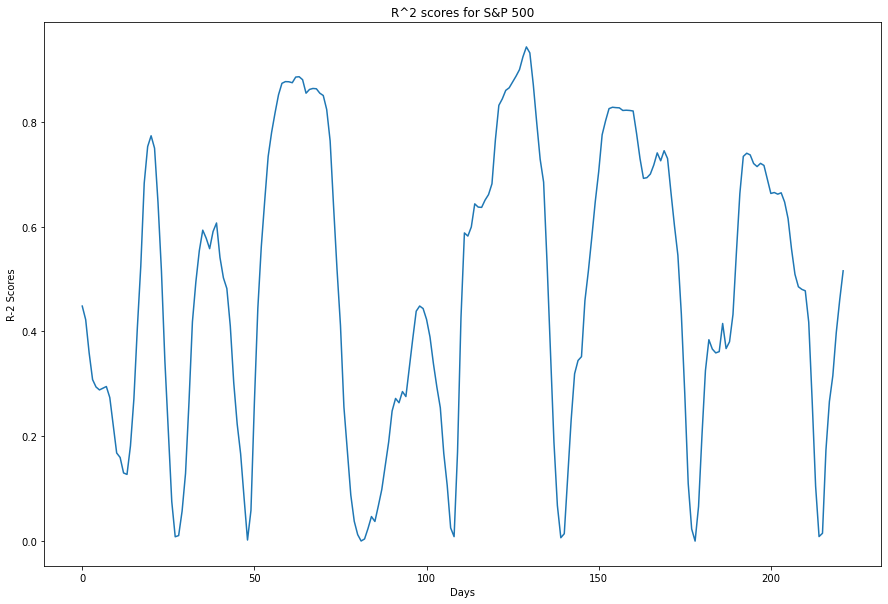

Average R^2 value -> 0.478461854100019


In [14]:
get_r2_score(df_spy_yr2, "S&P 500", 29)

In [15]:
def get_long_short_positions(df, w_best, stocks):
    w_star = w_best
    for j in range(df.shape[0]-w_star):
        prev_days = df.iloc[j:j+w_star, :]
        x = np.arange(1, w_star+1).reshape(-1, 1)
        y = prev_days["Adj Close"].values.reshape(-1, 1)
        lm_i = LinearRegression().fit(x, y)
        prediction_next = lm_i.predict(np.array([w_star+1]).reshape(-1, 1))
        df.iat[j+w_star, -1] = prediction_next
        
    position = None
    long, short = [], []
    long_position, short_position = 0, 0
    for j in range(w_star, df.shape[0] - 1):
        if df.iloc[j, -1] > df.iloc[j, 4]:
            if position == "Short":
                short.append(df.iloc[j, 4] - sp)
                short_position += 1
            position = "Long"
            lp = df.iloc[j, 4]
        
        elif df.iloc[j, -1] < df.iloc[j, 4]:
            if position == "Long":
                long.append(lp - df.iloc[j, 4])
                long_position += 1
            position = "Short"
            sp = df.iloc[j, 4]

    if position == "Long":
        long.append(lp - df.iloc[-1, 4])
        long_position += 1
    elif position == "Short":
        short.append(df.iloc[-1, 4] - sp)
        short_position += 1
    
    print(f"Total Short Positions in {stocks} -> {short_position}")
    print(f"Average Short Position Value for {stocks} -> $ {np.mean(short)}")
    print(f"Total Long Positions in {stocks} -> {long_position}")
    print(f"Average Long Position Value for {stocks} -> $ {np.mean(long)}")

In [16]:
get_long_short_positions(df_atvi_yr2, 5, "Activision Blizzard")

Total Short Positions in Activision Blizzard -> 45
Average Short Position Value for Activision Blizzard -> $ -0.5060430734394531
Total Long Positions in Activision Blizzard -> 44
Average Long Position Value for Activision Blizzard -> $ -0.36299254679376763


In [17]:
get_long_short_positions(df_spy_yr2, 29, "S&P 500")

Total Short Positions in S&P 500 -> 21
Average Short Position Value for S&P 500 -> $ -7.263732914285716
Total Long Positions in S&P 500 -> 20
Average Long Position Value for S&P 500 -> $ -8.483555604999996


In [18]:
def get_long_short_days(df, w_best, stocks):
    w_star = w_best
    for j in range(df.shape[0]-w_star):
        prev_days = df.iloc[j:j+w_star, :]
        x = np.arange(1, w_star+1).reshape(-1, 1)
        y = prev_days["Adj Close"].values.reshape(-1, 1)
        lm_i = LinearRegression().fit(x, y)
        prediction_next = lm_i.predict(np.array([w_star+1]).reshape(-1, 1))
        df.iat[j+w_star, -1] = prediction_next
        
    start, curr = None, None
    long, short = [], []

    for j in range(w_star, df.shape[0] - 1):
        if df.iloc[j, -1] > df.iloc[j, 4] and curr != "Long":
            if curr == "Short":
                short.append(j - start)
            start = j
            curr = "Long"
        
        elif df.iloc[j, -1] < df.iloc[j, 4] and curr != "Short":
            if curr == "Long":
                long.append(j - start)
            start = j
            curr = "Short"
    
    if curr == "Long":
        long.append(df.shape[0] - 1 - start)
    elif curr == "Short":
        short.append(df.shape[0] - 1 - start)
    
    print(f"Average Long Days for {stocks} -> {np.mean(long)}")
    print(f"Average Short Days for {stocks} -> {np.mean(short)}")

In [19]:
get_long_short_days(df_atvi_yr2, 5, "Activision Blizzard")

Average Long Days for Activision Blizzard -> 2.5
Average Short Days for Activision Blizzard -> 3.0


In [20]:
get_long_short_days(df_spy_yr2, 29, "S&P 500")

Average Long Days for S&P 500 -> 5.5
Average Short Days for S&P 500 -> 5.285714285714286


In [21]:
print("For Year 1- >")
get_long_short_positions(df_atvi_yr1, 5, "Activision Blizzard")
get_long_short_days(df_atvi_yr1, 5, "Activision Blizzard")
get_long_short_positions(df_spy_yr1, 29, "S&P 500")
get_long_short_days(df_spy_yr1, 29, "S&P 500")
print("\n")
print("For Year 2 ->")
get_long_short_positions(df_atvi_yr2, 5, "Activision Blizzard")
get_long_short_days(df_atvi_yr2, 5, "Activision Blizzard")
get_long_short_positions(df_spy_yr2, 29, "S&P 500")
get_long_short_days(df_spy_yr2, 29, "S&P 500")

For Year 1- >
Total Short Positions in Activision Blizzard -> 47
Average Short Position Value for Activision Blizzard -> $ -1.1454743727854892
Total Long Positions in Activision Blizzard -> 47
Average Long Position Value for Activision Blizzard -> $ -0.9512328295171201
Average Long Days for Activision Blizzard -> 2.5531914893617023
Average Short Days for Activision Blizzard -> 2.6808510638297873
Total Short Positions in S&P 500 -> 15
Average Short Position Value for S&P 500 -> $ -2.067419426666667
Total Long Positions in S&P 500 -> 14
Average Long Position Value for S&P 500 -> $ -4.0706830571428485
Average Long Days for S&P 500 -> 7.071428571428571
Average Short Days for S&P 500 -> 8.2


For Year 2 ->
Total Short Positions in Activision Blizzard -> 45
Average Short Position Value for Activision Blizzard -> $ -0.5060430734394531
Total Long Positions in Activision Blizzard -> 44
Average Long Position Value for Activision Blizzard -> $ -0.36299254679376763
Average Long Days for Activision